# Data Preparation

This notebook converts transaction information to individual records from pings.csv by driver ID. 
The records are the merged to drivers.csv. Given driver_id and date, you should predict online_hours.
In summary, the data preparation stage involves threes parts. First transaction information is converted to long format individual records from pings.csv by driver ID. Online hours are computed by counting the number of pings on any given day. Drivers without any ping data on a day are assumed to be offline on that day i.e. 0 hours online. The records are then merged to drivers.csv which contain additional static information (age, gender, etc.) on driver ID. 

**Inputs:**       
1. *drivers.csv: * This file contains driver profile data
1. *pings.csv: * This file contains the driver pings
              
**Outputs:**     
1. *merged_driver_and_ping_data.csv*
1. *sequence_merged_driver_and_ping_data.csv*

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import os
import datetime
import numpy as np

In [6]:
# define parameters
CWD = os.getcwd()
DATA = CWD + "\\data\\"

In [7]:
# data prep helper functions
def read_csv(path, sep=",", sortby=[]):
    '''
    read csv files
    '''
    # load data
    data = pd.read_csv(path, sep=sep)
    
    # sort and reindex
    data = data.sort_values(sortby, ascending=False)
    data = data.reset_index(drop=True)
    
    print("Data loading & sorting completed")
    print("Total Observation: ", data.shape[0])
    return data

def check_data(data):
    '''
    check data for duplicates and missing values
    '''
    # Drop duplicates
    initial_nrow = data.shape[0]
    data.drop_duplicates()
    post_nrow = data.shape[0]
    print("Total duplicates dropped: ", initial_nrow - post_nrow)
    
    # Empty columns - Find NaN counts per columns
    null_columns = data.columns[data.isnull().any()]
    if len(null_columns)==0:
        print("No missing values")
    else:
        print("Missing values found in: ", null_columns)
        print("Missing counts in missing columns: ", data[null_columns].isnull().sum())

def prep_ping_data(data, uni_id, uni_dt):
    '''
    create dataset for online hours per day per driver
    '''
    driver_ping_summary = []

    id_counter = 0
    total_id = len(uni_id)
    days = len(uni_dt)
    
    for ID in uni_id:
        id_counter += 1
        tmp = data[data['driver_id'] == ID]
        day_counter = days + 1
        for dt in uni_dt:
            day_counter -= 1
            tmp_dt = tmp[tmp['ping_date'] == dt]
            if tmp_dt.shape[0] > 0:
                ping_interval = tmp_dt['ping_timestamp'].diff(-1)/ np.timedelta64(1, 's')
                total_ping = ping_interval[ping_interval <= 15].count()
                online_hr = int(round((total_ping * 15)/3600))
            else:
                 online_hr = 0 #assume 0 hrs driven if no pings
            driver_ping_summary.append({'driver_id':ID, 'date': dt ,'online_hrs': online_hr, 'day_count': day_counter})
        if id_counter % 248 == 0:
            print(("Completed driver {}/{}").format(id_counter, total_id))
    return pd.DataFrame(driver_ping_summary)

## Train Ping Data

Contains the following:

- driver_id: The id of the driver whose ping has been received. 
- ping_timestamp: The Unix epoch timestamp when ping was received by thesystem. Timezone is “Asia/Jakarta”.

In [8]:
# Load pings data and index
ping_data = read_csv(DATA+"pings.csv", sortby=['driver_id', 'ping_timestamp'])

Data loading & sorting completed
Total Observation:  50528701


In [9]:
# Check pings data for duplicates and missing values
check_data(ping_data)

Total duplicates dropped:  0
No missing values


In [10]:
# Convert Date
ping_data['ping_timestamp'] = pd.to_datetime(ping_data['ping_timestamp'], unit='s')
ping_data['ping_timestamp'] = ping_data['ping_timestamp'].dt.tz_localize('Asia/Jakarta')
ping_data['ping_date']= ping_data['ping_timestamp'].dt.date

In [11]:
# Determine time online per driver per day
uni_drive_id = ping_data['driver_id'].unique()
uni_ping_dt =  ping_data['ping_date'].unique()

In [12]:
# create dataset for online hours per day per driver
driver_ping_summary = prep_ping_data(ping_data, uni_drive_id, uni_ping_dt)

Completed driver 248/2480
Completed driver 496/2480
Completed driver 744/2480
Completed driver 992/2480
Completed driver 1240/2480
Completed driver 1488/2480
Completed driver 1736/2480
Completed driver 1984/2480
Completed driver 2232/2480
Completed driver 2480/2480


In [13]:
# check records
driver_ping_summary[0:5]

,driver_id,date,online_hrs,day_count
0,998229,2017-06-22,1,22
1,998229,2017-06-21,7,21
2,998229,2017-06-20,0,20
3,998229,2017-06-19,7,19
4,998229,2017-06-18,5,18


19


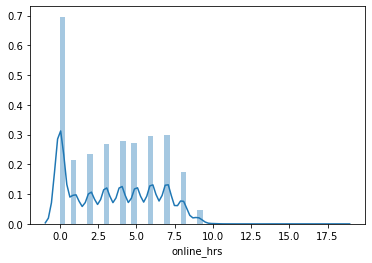

In [14]:
# plot online hours
sns.distplot(driver_ping_summary['online_hrs'])
print(len(driver_ping_summary['online_hrs'].unique()))

In [15]:
# pivot data - each row is one driver
piv_driver_ping_summary = driver_ping_summary.pivot_table(values='online_hrs', index='driver_id', columns='date')

In [16]:
# drop column 2017-06-22 which is in test
piv_driver_ping_summary = piv_driver_ping_summary.drop([pd.Timestamp('2017-06-22')], axis=1)

In [17]:
# check pivoted data
piv_driver_ping_summary[0:5]

date,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,...,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21
driver_id,,,,,,,,,,,,,,,,,,,,,
111556,2,2,0,0,4,2,2,3,4,0,...,3,4,2,1,0,0,0,0,2,3
111575,6,0,0,0,3,6,7,5,0,0,...,5,6,6,6,0,0,0,8,7,5
111779,3,3,0,0,0,3,1,4,1,0,...,0,2,4,2,4,0,0,0,3,3
111839,7,7,7,7,7,5,5,6,6,7,...,5,6,5,6,7,6,5,7,5,6
112486,3,3,0,0,4,4,1,4,3,0,...,1,0,2,1,3,0,0,2,3,4


## Driver Data

Contains the following:

- driver_id: Unique driver id
- gender: Gender of the driver
- age: Driver’s age
- number_of_kids: The number of kids the driver has

In [18]:
# Load driver data and reindex
driver_data = read_csv(DATA+"drivers.csv", sortby=['driver_id'])

Data loading & sorting completed
Total Observation:  2500


In [19]:
# Check driver data for duplicates and missing values
check_data(driver_data)

Total duplicates dropped:  0
No missing values


## Merge Ping & Driver Data

In [20]:
# merge driver data and driver ping summary data
merged_data = pd.merge(piv_driver_ping_summary, driver_data, how='left', on=['driver_id'])

# create indicator variables
merged_data['isMALE'] = (merged_data['gender'] == "MALE").astype(int)
merged_data['hasKids'] = (merged_data['number_of_kids'] > 0).astype(int)

# Show sample
print(merged_data.shape)
merged_data[0:5]

(2483, 27)


,driver_id,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,...,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,gender,age,number_of_kids,isMALE,hasKids
0,111556,2,2,0,0,4,2,2,3,4,...,0,0,0,2,3,FEMALE,49,4,0,1
1,111575,6,0,0,0,3,6,7,5,0,...,0,0,8,7,5,MALE,49,0,1,0
2,111779,3,3,0,0,0,3,1,4,1,...,0,0,0,3,3,MALE,26,0,1,0
3,111839,7,7,7,7,7,5,5,6,6,...,6,5,7,5,6,MALE,25,0,1,0
4,112486,3,3,0,0,4,4,1,4,3,...,0,0,2,3,4,FEMALE,44,1,0,1


In [21]:
# save csv
merged_data.to_csv(DATA+"merged_driver_and_ping_data.csv", index=True)

## Sequence Merged Ping & Driver Data
Create multiple sequences for merged ping and driver data

In [22]:
def strided_app(a, L, S, index, tstart, tend, auxstart, auxend):  
    '''
    creates a strided dataset for each driver
    Modified from https://stackoverflow.com/questions/40084931/taking-subarrays-from-numpy-array-with-given-stride-stepsize
    Window len = L, Stride len/stepsize = S
    tstart, tend = start and end column time features
    auxstart, auxend = start and end column auxillary features
    '''
    a_main = a.iloc[tstart:tend]
    nrows = ((a_main.size-L)//S)+1
    n = a_main.strides[0]
    a_new = np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))
    
    other_vars = np.tile(a[auxstart:auxend], (nrows,1))
    a_new_all = np.zeros((nrows, L+(auxend-auxstart)))
    
    
    a_new_all[:,0:L] = a_new
    a_new_all[:,L:] = other_vars
    a_new_all = pd.DataFrame(a_new_all)
    a_new_all = a_new_all.set_index(index.repeat(nrows))
    return a_new_all


def prepare_lstm_data(data, window, stride, tstart, tend, auxstart, auxend):
    '''
    convert the data for lstm
    '''
    ind = data.index
    transformed_data = pd.DataFrame()
    for j in range(len(data)):
        transformed_data = transformed_data.append(strided_app(data.iloc[j], window, stride, ind[j], tstart, tend, auxstart, auxend))
    transformed_data.columns = ["day_{}".format(i) for i in range(0,window)] + ["age", "number_of_kids", "isMALE"]
    return transformed_data


In [23]:
# Define data preparation parameters
t_start, t_end = 0, 21
aux_start, aux_end = 21, 24
window = 8
stride = 1

In [24]:
index_merged_data = merged_data.set_index(['driver_id'])
index_merged_data = index_merged_data.drop(['gender', 'hasKids'], axis=1)

In [25]:
transformed_data = prepare_lstm_data(index_merged_data, window, stride, t_start, t_end, aux_start, aux_end)

"Original data: {} was modified to {}".format(index_merged_data.shape, transformed_data.shape)

c:\users\julian.addison\appdata\local\continuum\anaconda3\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Series.strides is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


'Original data: (2483, 24) was modified to (34762, 11)'

In [26]:
# save csv
transformed_data.to_csv(DATA+"sequence_merged_driver_and_ping_data.csv", index=True)